In [16]:
!pip install lpips

In [17]:

#!unzip -q /content/NH-HAZE.zip -d /content/nh_haze_data/
#!ls /content/nh_haze_data/

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import torch.cuda.amp as amp

# Configuration
class Config:
    height = 128
    width = 128
    lr = 0.0002
    epochs = 10
    batch_size = 8
    val_batch_size = 1

    data_dir = "/content/nh_haze_data/NH-HAZE/NH-HAZE/"
    save_model_path = "dehazer_best.pth"
    subset_limit = 30

config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_fn = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [19]:
class ResLayer(nn.Module):
    def __init__(self, channel):
        super(ResLayer, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 1, 1, 0, bias=True)
        self.in1 = nn.InstanceNorm2d(channel, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(channel, channel, 3, 1, 1, bias=True)
        self.in4 = nn.InstanceNorm2d(channel, affine=True)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.in4(self.conv4(y))
        return self.relu(x + y)

class DehazeNet(nn.Module):
    def __init__(self, gps=3, dim=64):
        super(DehazeNet, self).__init__()
        self.gps, self.dim = gps, dim
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, dim, 3, 1, 1)
        self.in2 = nn.InstanceNorm2d(dim, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.ModuleList([ResLayer(dim) for _ in range(7)])
        self.ca = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(dim*gps, (dim*gps)//8, 1), nn.ReLU(), nn.Conv2d((dim*gps)//8, dim*gps, 1), nn.Sigmoid())
        self.pa = nn.Sequential(nn.Conv2d(dim, dim//8, 1), nn.ReLU(), nn.Conv2d(dim//8, 1, 1), nn.Sigmoid())
        self.conv3 = nn.Conv2d(dim, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 3, 3, 1, 1)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y1 = self.relu(self.in2(self.conv2(y)))
        res = y1
        feats = [y1]
        for i, layer in enumerate(self.res_blocks):
            res = layer(res)
            if i == 3 or i == 6: feats.append(res)
        y_cat = torch.cat(feats, dim=1)
        att = self.ca(y_cat).view(-1, self.gps, self.dim, 1, 1)
        y = att[:,0]*feats[0] + att[:,1]*feats[1] + att[:,2]*feats[2]
        y = y * self.pa(y)
        y = self.relu(nn.InstanceNorm2d(32)(self.conv3(y)))
        return self.relu(x + self.conv4(y))

In [20]:
class NHHazeDataset(Dataset):
    def __init__(self, data_dir):
        hazy_files = sorted(glob.glob(os.path.join(data_dir, "*_hazy.png")))
        self.data_list = []
        for h_path in hazy_files:
            gt_path = h_path.replace("_hazy.png", "_GT.png")
            if os.path.exists(gt_path):
                self.data_list.append((h_path, gt_path))

        if len(self.data_list) > config.subset_limit:
            self.data_list = self.data_list[:config.subset_limit]

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        h_path, g_path = self.data_list[idx]
        hazy = cv2.cvtColor(cv2.imread(h_path), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(g_path), cv2.COLOR_BGR2RGB)
        hazy = cv2.resize(hazy, (config.width, config.height)) / 255.0
        gt = cv2.resize(gt, (config.width, config.height)) / 255.0
        return torch.from_numpy(hazy).float().permute(2,0,1), torch.from_numpy(gt).float().permute(2,0,1)

full_ds = NHHazeDataset(config.data_dir)
indices = list(range(len(full_ds)))
np.random.seed(42)
np.random.shuffle(indices)

# 70-15-15 Split logic
t_size = int(0.7 * len(full_ds))
v_size = int(0.15 * len(full_ds))

train_loader = DataLoader(Subset(full_ds, indices[:t_size]), batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(Subset(full_ds, indices[t_size:t_size+v_size]), batch_size=1)
test_loader = DataLoader(Subset(full_ds, indices[t_size+v_size:]), batch_size=1)

In [21]:
def calculate_metrics(pred, gt):
    # Convert to numpy for skimage
    p_np = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)[0]
    g_np = gt.detach().cpu().numpy().transpose(0, 2, 3, 1)[0]

    mse = np.mean((p_np - g_np)**2)
    psnr = peak_signal_noise_ratio(g_np, p_np, data_range=1.0)
    ssim = structural_similarity(g_np, p_np, channel_axis=-1, data_range=1.0)

    # LPIPS expects input in range [-1, 1]
    lpips_score = lpips_fn(pred * 2 - 1, gt * 2 - 1).item()

    return mse, psnr, ssim, lpips_score

def evaluate_and_report(model, loader, dataset_name="Dataset"):
    model.eval()
    all_metrics = []
    with torch.no_grad():
        for h, g in loader:
            h, g = h.to(device), g.to(device)
            out = torch.clamp(model(h), 0, 1)
            all_metrics.append(calculate_metrics(out, g))

    avgs = np.mean(all_metrics, axis=0)
    print(f"\n--- {dataset_name} Metrics ---")
    print(f"Average MSE:   {avgs[0]:.6f}")
    print(f"Average PSNR:  {avgs[1]:.4f}")
    print(f"Average SSIM:  {avgs[2]:.4f}")
    print(f"Average LPIPS: {avgs[3]:.4f}")

In [23]:


model = DehazeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = nn.L1Loss() 
scaler = amp.GradScaler()

print("Starting 15-Minute Sprint Training...")
for epoch in range(config.epochs):
    model.train()
    for h, g in train_loader:
        h, g = h.to(device), g.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            loss = criterion(model(h), g)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print(f"Epoch {epoch+1} Complete")


def final_eval(loader, name):
    model.eval()
    ms, ps, ss, lp = [], [], [], []
    with torch.no_grad():
        for h, g in loader:
            h, g = h.to(device), g.to(device)
            out = torch.clamp(model(h), 0, 1)

           
            lp_batch = lpips_fn(out * 2 - 1, g * 2 - 1)
            lp.append(lp_batch.mean().item())

            
            p_np_batch = out.cpu().numpy().transpose(0, 2, 3, 1)
            g_np_batch = g.cpu().numpy().transpose(0, 2, 3, 1)

            for i in range(p_np_batch.shape[0]):
                p_np = p_np_batch[i]
                g_np = g_np_batch[i]

                ms.append(np.mean((p_np - g_np)**2))
                ps.append(peak_signal_noise_ratio(g_np, p_np, data_range=1.0))
                ss.append(structural_similarity(g_np, p_np, channel_axis=-1, data_range=1.0))

    print(f"\n{name} Set Results:")
    print(f"MSE: {np.mean(ms):.5f} | PSNR: {np.mean(ps):.2f} | SSIM: {np.mean(ss):.4f} | LPIPS: {np.mean(lp):.4f}")

/tmp/ipython-input-2995430321.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Starting 15-Minute Sprint Training...


/tmp/ipython-input-2995430321.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1 Complete
Epoch 2 Complete
Epoch 3 Complete
Epoch 4 Complete
Epoch 5 Complete
Epoch 6 Complete
Epoch 7 Complete
Epoch 8 Complete
Epoch 9 Complete
Epoch 10 Complete


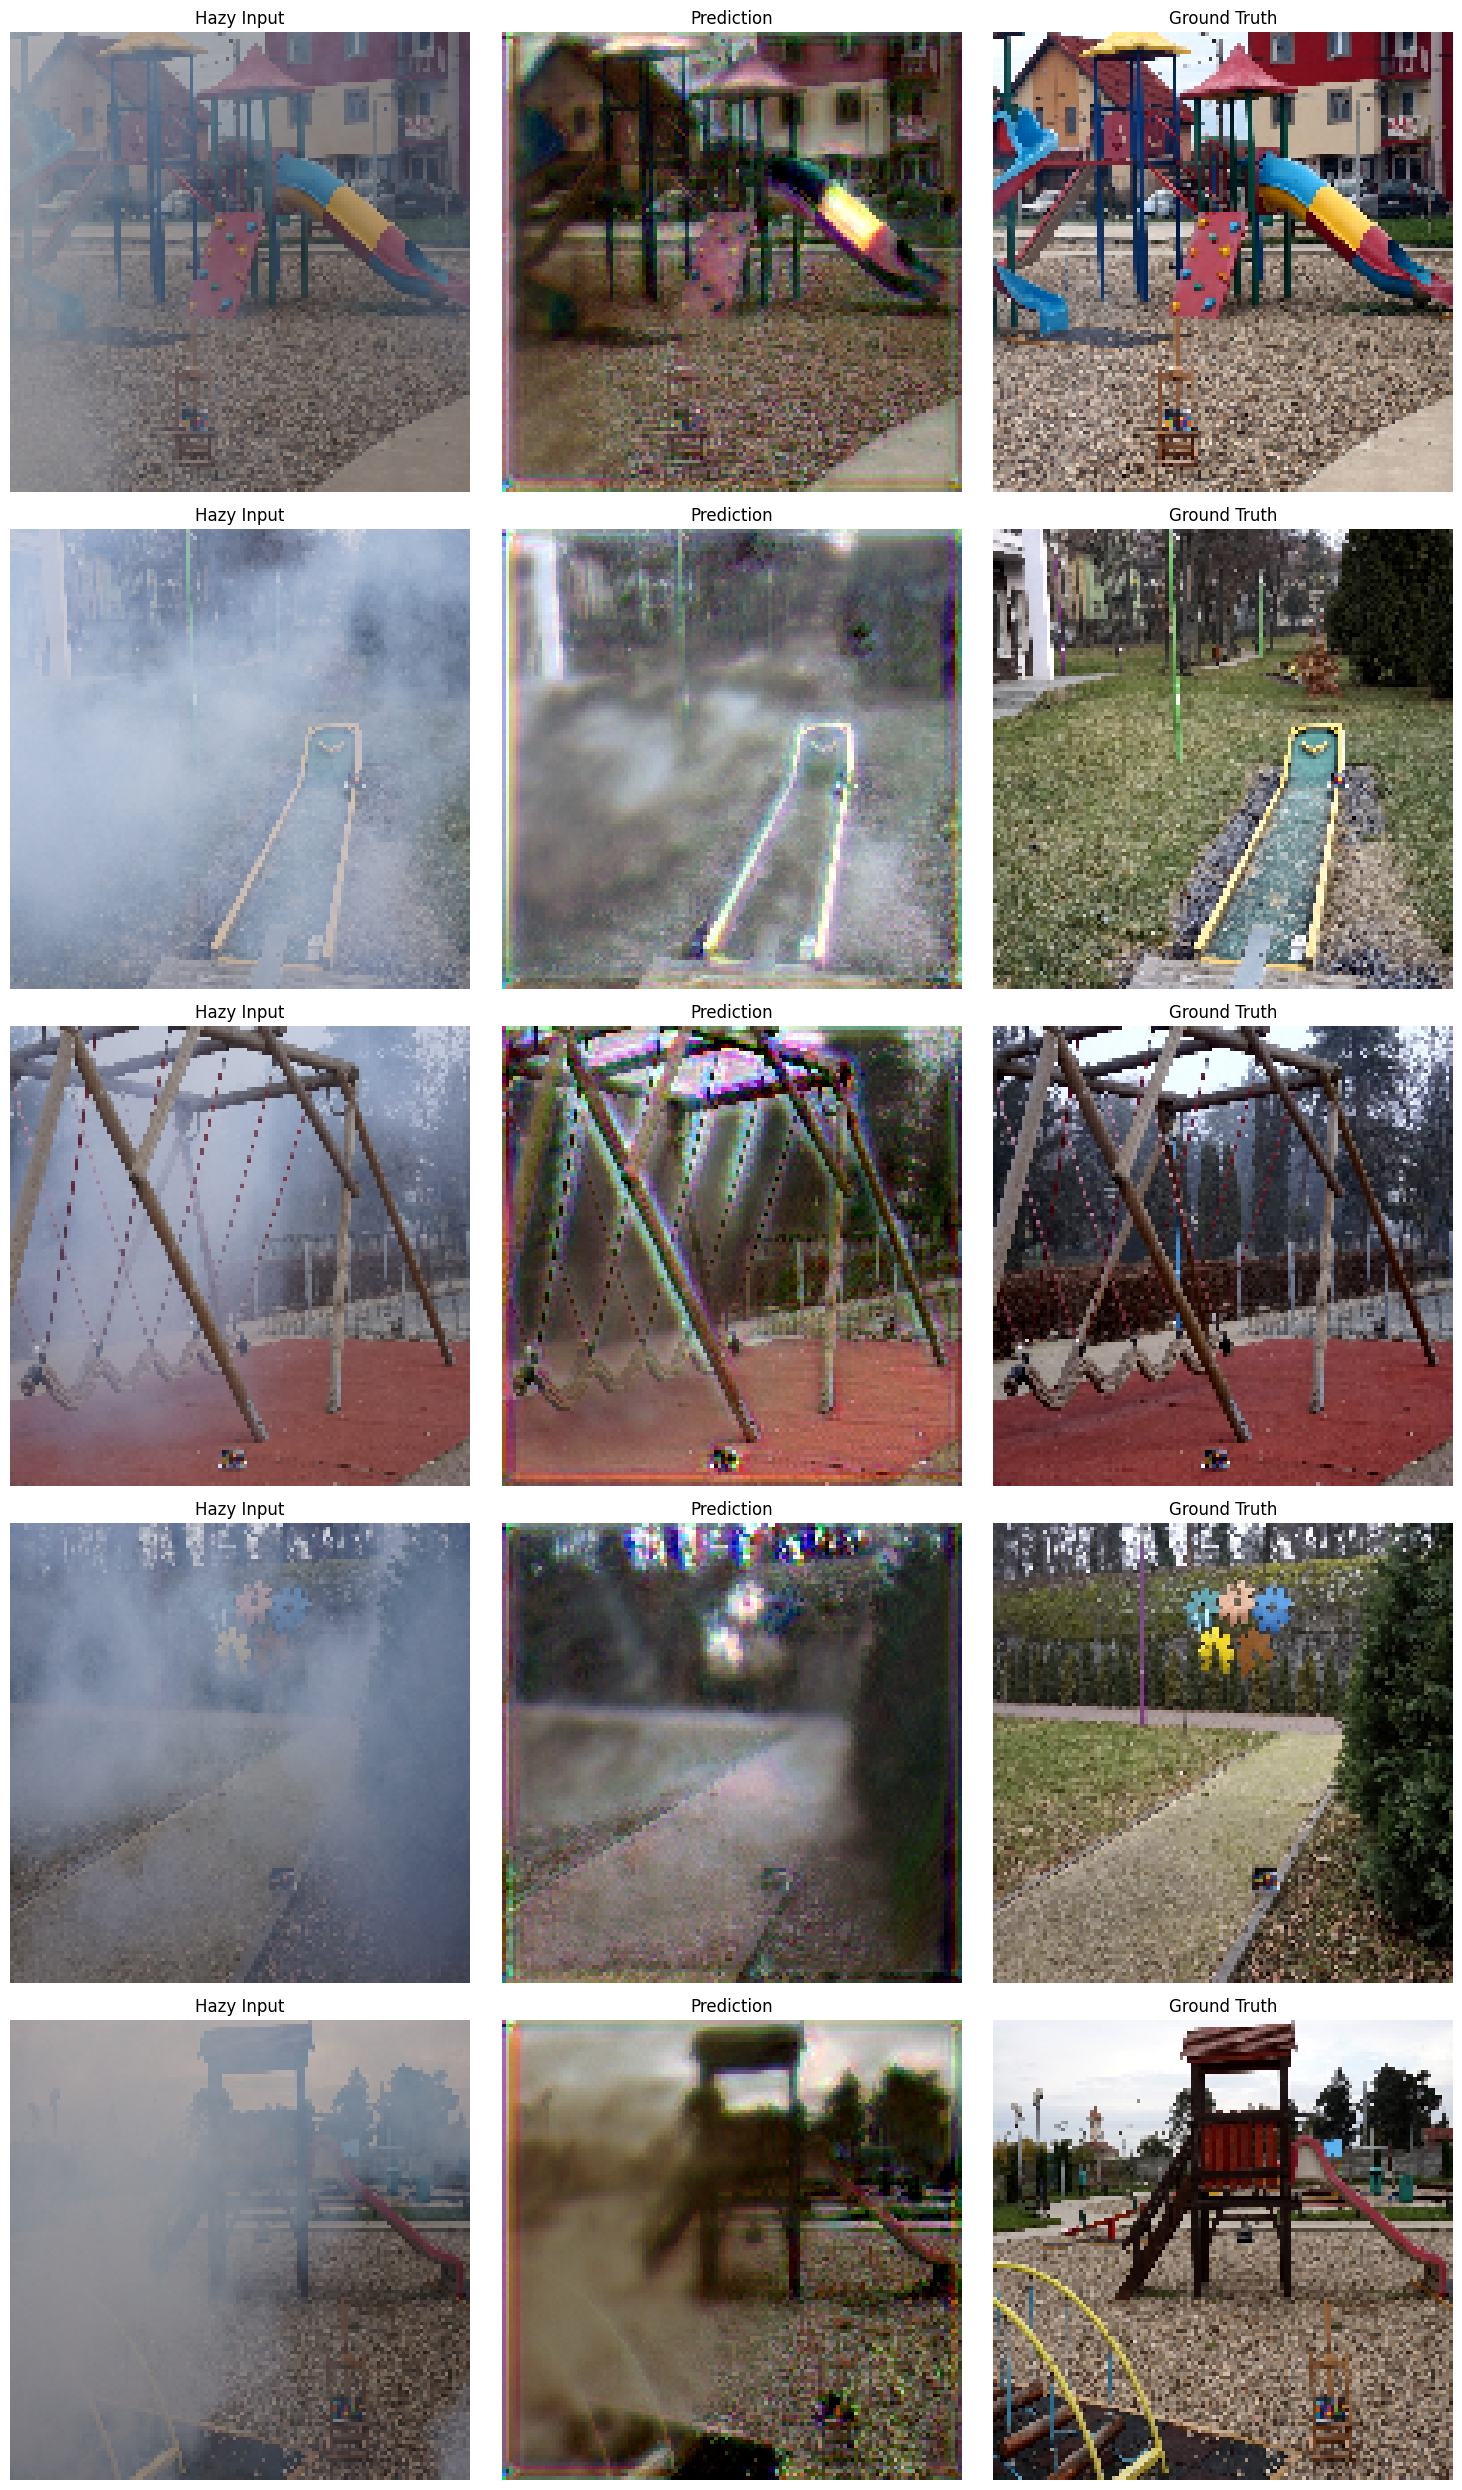

In [24]:
model.eval()

num_show = min(10, len(test_loader))
fig, axes = plt.subplots(num_show, 3, figsize=(15, 5 * num_show))

with torch.no_grad():
    for i, (h, g) in enumerate(test_loader):
        if i >= num_show: break
        out = torch.clamp(model(h.to(device)), 0, 1)
        axes[i, 0].imshow(h[0].permute(1,2,0)); axes[i,0].set_title("Hazy Input"); axes[i,0].axis('off')
        axes[i, 1].imshow(out[0].cpu().permute(1,2,0)); axes[i,1].set_title("Prediction"); axes[i,1].axis('off')
        axes[i, 2].imshow(g[0].permute(1,2,0)); axes[i,2].set_title("Ground Truth"); axes[i,2].axis('off')

plt.tight_layout()
plt.show()